# Bank Churn
  
  <br/><br/>
 

This project aims to identify the most important factors leading to customer churn for a commercial bank.

- 11 tables
- A variety of indexes, primary and foreign key constraints
- Over 15,000 rows of data  


  
Finally, we will export the database tables in **CSV** format, which will be used to create a semantic model in **Power BI** and related dashboards in the next step.  
  
  <br/><br/>

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings

In [2]:
# run to avoid warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=0.8)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Importing Data

In [4]:
# create a dataframe from CSV
df = pd.read_csv('../data/0-external/Churn_Banking_Modeling.csv', low_memory=False, encoding='latin-1')
df

,Id_Cliente,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,...,Imp_Liquidità_Attuale,Imp_Gestito_attuale,Imp_Amministrato_attuale,Imp_Liquidità_Attuale_6m,Imp_Gestito_attuale_6m,Imp_Amministrato_attuale_6m,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID
0,2,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,...,1634.57,2978.40,2980.92,1550.44,2853.20,2853.22,0,0,0,0
1,3,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,...,11918.26,NaN,34916.15,26122.17,NaN,22053.82,0,0,0,0
2,4,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,...,2671.95,NaN,232776.62,16545.25,NaN,216304.33,1,0,0,0
3,5,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,...,19211.31,15013.53,15017.53,12500.00,NaN,NaN,0,0,0,0
4,7,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,...,1526.38,NaN,NaN,1427.70,NaN,21514.60,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377364,555146,no,5317.47,1,0,49.0,NaN,NaN,2008.0,Avvocato,...,27933.94,197987.97,239399.96,31673.56,243236.45,285346.45,0,0,0,0
377365,555147,no,17.35,0,0,42.0,CT,CT,2002.0,Docente/Insegnante,...,-909.87,NaN,NaN,-2782.54,NaN,1098.68,0,0,0,0
377366,555148,no,334.73,0,0,54.0,RM,BZ,2001.0,Medico/Farmacista,...,72535.85,NaN,15017.53,66142.32,NaN,15208.61,0,0,0,0
377367,555149,no,5171.38,0,0,60.0,GE,GE,2007.0,Libero professionista/Titolare di impresa,...,115.87,338644.32,339296.07,154.64,276199.41,276199.47,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377369 entries, 0 to 377368
Data columns (total 43 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Id_Cliente                           377369 non-null  int64  
 1   Flag_Richiesta_Estinzione_cc         377369 non-null  object 
 2   Imp_Valore_del_Cliente               377369 non-null  float64
 3   Flag_Apertura_Conto_Online           377369 non-null  int64  
 4   Flag_Possesso_piu_Conti              377369 non-null  int64  
 5   Eta                                  377362 non-null  float64
 6   Provincia_Domicilio                  356181 non-null  object 
 7   Provincia_Residenza                  357897 non-null  object 
 8   Anno_Apertura_primo_Conto            377369 non-null  float64
 9   Professione                          341172 non-null  object 
 10  Imp_Reddito                          157476 non-null  object 
 11  Tipologia_Cli

Column names are in **Italian**, they will be translated into English for clarity.

In [6]:
# update column names
df.columns = ['customer_id', 'flag_closure_request', 'amt_cust_value', 'flag_online_acc_opening',
              'flag_mult_account_ownership', 'num_cust_age', 'prov_domicile', 'prov_residence', 'num_first_account_year',
              'cust_profession', 'amt_cust_income', 'cust_type', 'cust_gender', 'mifid_profile', 'amt_pricing_fee',
              'amt_transfer_to_competitors', 'amt_tranfers_to_non_competitors', 'num_existing_services',
              'flag_salary_deposit', 'amt_credit_card_spending', 'amt_debit_card_spending', 'num_website_access_count',
              'num_transactions_count', 'num_trading_activities_count', 'num_change_services', 'flag_mortgage',
              'flag_loan', 'flag_internal_tranfers', 'flag_info_closure_request', 'flag_loyalty_program_enrol',
              'flag_call_center_contact', 'flag_salary_deposit_variation', 'num_loyalty_points', 'amt_current_liquidity',
              'amt_current_managed', 'amt_current_administered', 'amt_6m_current_liquidity', 'amt_6m_current_managed',
              'amt_6m_current_administered', 'flag_outgoing_sec_tranfer', 'flag_card_rejection', 'flag_loan_rejection',
              'flag_rid_deactivation']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377369 entries, 0 to 377368
Data columns (total 43 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   customer_id                      377369 non-null  int64  
 1   flag_closure_request             377369 non-null  object 
 2   amt_cust_value                   377369 non-null  float64
 3   flag_online_acc_opening          377369 non-null  int64  
 4   flag_mult_account_ownership      377369 non-null  int64  
 5   num_cust_age                     377362 non-null  float64
 6   prov_domicile                    356181 non-null  object 
 7   prov_residence                   357897 non-null  object 
 8   num_first_account_year           377369 non-null  float64
 9   cust_profession                  341172 non-null  object 
 10  amt_cust_income                  157476 non-null  object 
 11  cust_type                        377369 non-null  object 
 12  cu

In [8]:
# check for missing values
df.isnull().sum()

customer_id                             0
flag_closure_request                    0
amt_cust_value                          0
flag_online_acc_opening                 0
flag_mult_account_ownership             0
num_cust_age                            7
prov_domicile                       21188
prov_residence                      19472
num_first_account_year                  0
cust_profession                     36197
amt_cust_income                    219893
cust_type                               0
cust_gender                             7
mifid_profile                       49257
amt_pricing_fee                     27396
amt_transfer_to_competitors        288655
amt_tranfers_to_non_competitors    176679
num_existing_services              167432
flag_salary_deposit                     0
amt_credit_card_spending           164706
amt_debit_card_spending            176004
num_website_access_count            50199
num_transactions_count              61605
num_trading_activities_count      

In [9]:
# display the statistical summary of the numerical features
df.describe()

,customer_id,amt_cust_value,flag_online_acc_opening,flag_mult_account_ownership,num_cust_age,num_first_account_year,amt_pricing_fee,amt_transfer_to_competitors,amt_tranfers_to_non_competitors,num_existing_services,...,amt_current_liquidity,amt_current_managed,amt_current_administered,amt_6m_current_liquidity,amt_6m_current_managed,amt_6m_current_administered,flag_outgoing_sec_tranfer,flag_card_rejection,flag_loan_rejection,flag_rid_deactivation
count,377369.000000,377369.000000,377369.000000,377369.000000,377362.000000,377369.000000,349973.000000,8.871400e+04,2.006900e+05,209937.000000,...,3.773640e+05,1.111880e+05,1.876340e+05,3.773560e+05,1.109000e+05,1.862980e+05,377369.000000,377369.000000,377369.000000,377369.000000
mean,277680.735847,644.662654,0.234230,0.071818,46.039890,2004.805750,0.903291,3.183130e+03,3.352734e+03,4.454517,...,1.513478e+04,6.770461e+04,7.614477e+04,1.532084e+04,6.554481e+04,7.233862e+04,0.008358,0.000917,0.008008,0.000845
std,160279.531097,2928.725757,0.423517,0.258187,13.146689,3.288509,1.825685,1.423111e+04,1.511987e+04,3.636854,...,5.204623e+04,1.940914e+05,2.669638e+05,5.201275e+04,1.780930e+05,2.637481e+05,0.091039,0.030266,0.089129,0.029062
min,2.000000,0.000000,0.000000,0.000000,3.000000,1994.000000,0.000000,1.000000e-02,1.000000e-02,1.000000,...,-2.998609e+06,0.000000e+00,0.000000e+00,-2.990061e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,138834.000000,46.870000,0.000000,0.000000,37.000000,2002.000000,0.000000,1.575825e+02,3.500000e+02,2.000000,...,6.292100e+02,7.880375e+03,4.966840e+03,6.313775e+02,7.808850e+03,4.937938e+03,0.000000,0.000000,0.000000,0.000000
50%,277965.000000,97.270000,0.000000,0.000000,43.000000,2005.000000,0.000000,4.790000e+02,8.058555e+02,3.000000,...,3.850860e+03,2.329358e+04,2.084153e+04,3.788385e+03,2.284953e+04,2.016169e+04,0.000000,0.000000,0.000000,0.000000
75%,416378.000000,370.320000,0.000000,0.000000,54.000000,2008.000000,0.325000,1.500000e+03,2.047996e+03,6.000000,...,1.417872e+04,6.469545e+04,6.766876e+04,1.397786e+04,6.297351e+04,6.434840e+04,0.000000,0.000000,0.000000,0.000000
max,555150.000000,377934.870000,1.000000,1.000000,132.000000,2010.000000,5.950000,1.100000e+06,1.130700e+06,40.000000,...,1.686020e+07,1.736378e+07,4.808764e+07,1.486619e+07,1.838148e+07,5.715864e+07,1.000000,1.000000,1.000000,1.000000


In [10]:
# save the modified dataframe as CSV
df.to_csv('../data/3-processed/df_00.csv', encoding='latin-1', index=False)

In [11]:
# load data from CSV for consistency reasons
df = pd.read_csv('../data/3-processed/df_00.csv', low_memory=False, encoding='latin-1')
df

,customer_id,flag_closure_request,amt_cust_value,flag_online_acc_opening,flag_mult_account_ownership,num_cust_age,prov_domicile,prov_residence,num_first_account_year,cust_profession,...,amt_current_liquidity,amt_current_managed,amt_current_administered,amt_6m_current_liquidity,amt_6m_current_managed,amt_6m_current_administered,flag_outgoing_sec_tranfer,flag_card_rejection,flag_loan_rejection,flag_rid_deactivation
0,2,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,...,1634.57,2978.40,2980.92,1550.44,2853.20,2853.22,0,0,0,0
1,3,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,...,11918.26,NaN,34916.15,26122.17,NaN,22053.82,0,0,0,0
2,4,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,...,2671.95,NaN,232776.62,16545.25,NaN,216304.33,1,0,0,0
3,5,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,...,19211.31,15013.53,15017.53,12500.00,NaN,NaN,0,0,0,0
4,7,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,...,1526.38,NaN,NaN,1427.70,NaN,21514.60,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377364,555146,no,5317.47,1,0,49.0,NaN,NaN,2008.0,Avvocato,...,27933.94,197987.97,239399.96,31673.56,243236.45,285346.45,0,0,0,0
377365,555147,no,17.35,0,0,42.0,CT,CT,2002.0,Docente/Insegnante,...,-909.87,NaN,NaN,-2782.54,NaN,1098.68,0,0,0,0
377366,555148,no,334.73,0,0,54.0,RM,BZ,2001.0,Medico/Farmacista,...,72535.85,NaN,15017.53,66142.32,NaN,15208.61,0,0,0,0
377367,555149,no,5171.38,0,0,60.0,GE,GE,2007.0,Libero professionista/Titolare di impresa,...,115.87,338644.32,339296.07,154.64,276199.41,276199.47,0,0,0,0


In [12]:
# display the unique values
df['flag_closure_request'].unique()

array(['no', 'si'], dtype=object)

The **'flag_closure_request'** column has no empty values and will be binarised for analytical purposes.

In [13]:
# convert 'flag_closure_request' column into binary
df.flag_closure_request[df.flag_closure_request == 'si'] = 1
df.flag_closure_request[df.flag_closure_request == 'no'] = 0
df['flag_closure_request'] = df['flag_closure_request'].astype('int64')
df

,customer_id,flag_closure_request,amt_cust_value,flag_online_acc_opening,flag_mult_account_ownership,num_cust_age,prov_domicile,prov_residence,num_first_account_year,cust_profession,...,amt_current_liquidity,amt_current_managed,amt_current_administered,amt_6m_current_liquidity,amt_6m_current_managed,amt_6m_current_administered,flag_outgoing_sec_tranfer,flag_card_rejection,flag_loan_rejection,flag_rid_deactivation
0,2,0,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,...,1634.57,2978.40,2980.92,1550.44,2853.20,2853.22,0,0,0,0
1,3,0,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,...,11918.26,NaN,34916.15,26122.17,NaN,22053.82,0,0,0,0
2,4,0,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,...,2671.95,NaN,232776.62,16545.25,NaN,216304.33,1,0,0,0
3,5,0,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,...,19211.31,15013.53,15017.53,12500.00,NaN,NaN,0,0,0,0
4,7,0,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,...,1526.38,NaN,NaN,1427.70,NaN,21514.60,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377364,555146,0,5317.47,1,0,49.0,NaN,NaN,2008.0,Avvocato,...,27933.94,197987.97,239399.96,31673.56,243236.45,285346.45,0,0,0,0
377365,555147,0,17.35,0,0,42.0,CT,CT,2002.0,Docente/Insegnante,...,-909.87,NaN,NaN,-2782.54,NaN,1098.68,0,0,0,0
377366,555148,0,334.73,0,0,54.0,RM,BZ,2001.0,Medico/Farmacista,...,72535.85,NaN,15017.53,66142.32,NaN,15208.61,0,0,0,0
377367,555149,0,5171.38,0,0,60.0,GE,GE,2007.0,Libero professionista/Titolare di impresa,...,115.87,338644.32,339296.07,154.64,276199.41,276199.47,0,0,0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377369 entries, 0 to 377368
Data columns (total 43 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   customer_id                      377369 non-null  int64  
 1   flag_closure_request             377369 non-null  int64  
 2   amt_cust_value                   377369 non-null  float64
 3   flag_online_acc_opening          377369 non-null  int64  
 4   flag_mult_account_ownership      377369 non-null  int64  
 5   num_cust_age                     377362 non-null  float64
 6   prov_domicile                    356181 non-null  object 
 7   prov_residence                   357897 non-null  object 
 8   num_first_account_year           377369 non-null  float64
 9   cust_profession                  341172 non-null  object 
 10  amt_cust_income                  157476 non-null  object 
 11  cust_type                        377369 non-null  object 
 12  cu

In [16]:
# display the unique values
df['Flag_Apertura_Conto_Online'].unique()

array([0, 1], dtype=int64)

In [17]:
# display the unique values
df['Eta'].unique()

array([ 38.,  45.,  61.,  33.,  36.,  48.,  51.,  44.,  63.,  32.,  66.,
        57.,  60.,  40.,  49.,  31.,  35.,  46.,  42.,  50.,  37.,  41.,
        39.,  47.,  71.,  77.,  54.,  70.,  24.,  78.,  55.,  58.,  30.,
        29.,  43.,  56.,  64.,  76.,  59.,  65.,  86.,  72.,  73.,  53.,
        81.,  62.,  68.,  34.,  74.,  27.,  26.,  28.,  79.,  69.,  19.,
        52.,  75.,  67.,  23.,  25.,  22.,  87.,  21.,  82.,  80.,  83.,
        85.,  91.,  97.,  84.,  90.,  89.,  20.,  94.,  88.,  18.,  92.,
        93.,  16.,  17.,  13., 102.,  99.,  96.,   5.,  11., 101.,  14.,
       132., 105.,  95.,  98.,  10.,   3.,   9., 100.,   7.,  nan,  12.,
         4.,   6.,   8.,  15.])

In [18]:
# display the unique values
df['Provincia_Domicilio'].unique()

array(['BO', 'SA', 'VT', 'MI', 'AL', 'NO', 'BZ', 'MO', 'CT', 'RN', 'RE',
       'FI', 'AV', 'PN', 'TR', 'GE', 'VI', 'FR', 'FM', 'CR', 'RM', nan,
       'TO', 'PD', 'CA', 'CE', 'SR', 'BI', 'PI', 'CO', 'CB', 'MN', 'PU',
       'AR', 'PA', 'TE', 'MB', 'VA', 'SP', 'BS', 'RA', 'CI', 'PV', 'FE',
       'LU', 'PR', 'PT', 'UD', 'MC', 'FG', 'LT', 'BA', 'PO', 'TA', 'LC',
       'VE', 'TP', 'PG', 'SI', 'TN', 'GO', 'TV', 'BG', 'MS', 'CH', 'VR',
       'FC', 'LI', 'GR', 'LE', 'VC', 'OR', 'LO', 'EE', 'AQ', 'SV', 'RC',
       'RG', 'SS', 'CS', 'PZ', 'AT', 'ME', 'CL', 'BR', 'MT', 'RO', 'TS',
       'PC', 'CN', 'AG', 'RI', 'PE', 'CZ', 'IM', 'AP', 'AN', 'BT', 'VS',
       'NU', 'BL', 'OT', 'OG', 'BN', 'VB', 'IS', 'AO', 'SO', 'EN', 'KR',
       'VV', 'PS', 'FO', '8N', 'BE'], dtype=object)

In [19]:
# display the unique values
df['Provincia_Residenza'].unique()

array(['BO', 'SA', 'VT', 'MI', 'AL', 'NO', 'BZ', 'MO', 'CT', 'RN', 'RE',
       'FI', 'AV', 'PN', 'TR', 'GE', 'VI', 'FR', 'FM', 'CR', 'RM', nan,
       'TO', 'PD', 'CA', 'CE', 'SR', 'BI', 'PI', 'CO', 'FC', 'CB', 'MN',
       'PU', 'BN', 'AR', 'PA', 'TE', 'MB', 'VA', 'BS', 'RA', 'CI', 'PV',
       'FE', 'LU', 'PR', 'PT', 'TS', 'MC', 'FG', 'LT', 'BA', 'PO', 'TA',
       'LC', 'GR', 'VE', 'TP', 'PG', 'SI', 'TN', 'GO', 'UD', 'TV', 'BG',
       'MS', 'CH', 'VR', 'LI', 'LE', 'VC', 'SP', 'SS', 'OR', 'LO', 'AQ',
       'CN', 'RC', 'RG', 'RO', 'CS', 'PZ', 'AT', 'ME', 'CL', 'SV', 'BR',
       'MT', 'PC', 'PE', 'AG', 'RI', 'CZ', 'IM', 'AP', 'AN', 'BT', 'VS',
       'NU', 'BL', 'OT', 'OG', 'VB', 'EE', 'AO', 'IS', 'SO', 'EN', 'KR',
       'VV', 'PS', 'FO'], dtype=object)

In [20]:
# display the unique values
df['Anno_Apertura_primo_Conto'].unique()

array([2004., 2000., 2005., 2010., 2001., 2008., 2002., 2007., 2003.,
       2006., 2009., 1999., 1994., 1995., 1998., 1996., 1997.])

In [21]:
# display the unique values
df['Professione'].unique()

array(['Impiegato', 'Altro/Nessuno', 'Quadro', 'Operaio', nan,
       'Ufficiale/Sottufficiale',
       'Libero professionista/Titolare di impresa', 'Dirigente',
       'Commercialista', 'Rappresentante/Agente', 'Ingegnere/Architetto',
       'Avvocato', 'Medico/Farmacista', 'Autotrasportatore',
       'Docente/Insegnante', 'Commesso/Ausiliario',
       'Ufficiale/Sottoufficiale',
       'Libero professionista/Titolare impresa', 'Notaio'], dtype=object)

In [22]:
# display the unique values
df['Imp_Reddito'].unique()

array(['Medio (tra 1500 e 1800)', 'Alto (tra 1800 e 2500)',
       'Basso (tra 1200 e 1500)', nan, 'Altissimo (>2500)',
       'Bassissimo (<1200)'], dtype=object)

In [23]:
# display the unique values
df['Tipologia_Cliente'].unique()

array(['Investor', 'Trader', 'ActiveTrader', 'Banker', 'Sleeper'],
      dtype=object)

In [24]:
# display the unique values
df['Profilo_MIFID'].unique()

array(['PRUDENTE', 'BILANCIATO', 'DINAMICO', nan, 'ND', 'CAUTO'],
      dtype=object)

In [25]:
# display the unique values
df['Num_Utenze_in_essere'].unique()

array([ 3.,  7.,  9., nan,  4.,  5., 14.,  1.,  2.,  6., 39.,  8., 13.,
       12., 15., 10., 11., 16., 19., 18., 20., 17., 27., 23., 21., 24.,
       22., 28., 25., 31., 26., 29., 30., 32., 38., 35., 40., 33.])

In [26]:
# display the unique values
df['Num_Accessi_Sito'].unique()

array([14., 25., 18.,  4., 16., nan, 12.,  1.,  5.,  6.,  3., 21., 19.,
        7.,  2., 23., 22.,  8., 24., 15., 10.,  9., 17., 20., 13., 11.,
       26., 27., 29., 28., 30.])

In [27]:
# display the unique values
df['Num_Movimenti_Dispositivi'].unique()

array([5.8000e+01, 8.0000e+00, 1.3000e+01, 4.0000e+00, 1.0000e+00,
              nan, 2.1000e+01, 1.0000e+01, 3.0000e+00, 7.0000e+00,
       1.5000e+01, 1.8000e+01, 1.1000e+01, 6.0000e+00, 1.2000e+01,
       9.0000e+00, 2.0000e+00, 3.4000e+01, 2.4000e+01, 5.0000e+00,
       2.6000e+01, 1.4000e+01, 2.0000e+01, 2.2000e+01, 1.6000e+01,
       1.7000e+01, 1.9000e+01, 2.5000e+01, 2.3000e+01, 3.3000e+01,
       2.8000e+01, 4.5000e+01, 3.6000e+01, 3.0000e+01, 4.0000e+01,
       3.2000e+01, 2.9000e+01, 3.7000e+01, 5.5000e+01, 3.5000e+01,
       3.1000e+01, 4.8000e+01, 2.7000e+01, 4.4000e+01, 4.2000e+01,
       5.0000e+01, 6.3000e+01, 4.7000e+01, 3.9000e+01, 4.1000e+01,
       3.8000e+01, 4.3000e+01, 5.1000e+01, 5.4000e+01, 7.1000e+01,
       5.6000e+01, 4.9000e+01, 4.6000e+01, 5.2000e+01, 5.3000e+01,
       6.1000e+01, 5.7000e+01, 6.0000e+01, 9.0000e+01, 1.1500e+02,
       1.0400e+02, 9.4000e+01, 6.5000e+01, 6.2000e+01, 7.4000e+01,
       6.4000e+01, 5.9000e+01, 6.8000e+01, 1.3300e+02, 6.6000e

In [28]:
# display the unique values
df['Num_attività_trading'].unique()

array([      nan, 2.000e+00, 7.000e+00, 7.200e+01, 1.000e+00, 8.000e+00,
       4.000e+00, 2.400e+01, 1.570e+02, 6.000e+00, 3.000e+00, 1.070e+02,
       1.000e+01, 3.700e+01, 7.300e+01, 9.000e+00, 1.300e+01, 5.000e+00,
       3.800e+01, 2.000e+01, 2.800e+01, 1.400e+01, 2.600e+01, 1.900e+01,
       3.000e+01, 1.700e+01, 3.490e+02, 3.500e+01, 4.070e+02, 5.810e+02,
       9.600e+01, 1.600e+01, 6.100e+01, 1.060e+02, 1.500e+01, 3.100e+01,
       3.200e+01, 1.200e+01, 6.700e+01, 2.100e+01, 2.200e+01, 1.100e+01,
       9.300e+01, 3.900e+01, 1.150e+02, 1.480e+02, 6.600e+02, 1.360e+02,
       1.800e+01, 6.600e+01, 9.700e+01, 4.300e+01, 4.600e+01, 4.100e+01,
       1.830e+02, 2.300e+01, 3.600e+01, 3.480e+02, 5.700e+01, 2.500e+01,
       2.610e+02, 9.500e+01, 3.520e+02, 5.400e+01, 8.300e+01, 8.800e+01,
       7.900e+01, 2.270e+02, 7.600e+01, 2.840e+02, 1.720e+02, 3.400e+01,
       2.900e+01, 6.500e+01, 2.700e+01, 1.260e+02, 1.730e+02, 2.070e+02,
       4.000e+01, 9.800e+01, 1.530e+02, 4.010e+02, 

In [29]:
# display the unique values
df['Var_Numero_Utenze'].unique()

array([  0.,   1.,  -1.,  nan,   2.,  -4., -23.,  -8.,  -5.,  -2.,  -7.,
        -6.,  -3.,   3., -11.,   4.,   5.,  15.,   7.,   6.,   8.,  10.,
        11.,  12., -14., -10.,   9.,  -9.,  16., -12.,  14., -13.,  22.,
        18., -16., -15.,  13.,  17.,  19., -17.,  21.,  20., -26.,  25.])

In [30]:
# check the value percentages for the 'Provincia_Domicilio' column
df.Provincia_Domicilio.value_counts(normalize=True)

RM    0.147911
MI    0.088186
TO    0.056567
BS    0.029061
GE    0.023951
        ...   
OG    0.000143
FO    0.000081
PS    0.000073
8N    0.000003
BE    0.000003
Name: Provincia_Domicilio, Length: 114, dtype: float64

In [31]:
# check the value percentages for the 'Provincia_Residenza' column
df.Provincia_Residenza.value_counts(normalize=True)

RM    0.140691
MI    0.081266
TO    0.055709
BS    0.029042
GE    0.024074
        ...   
EE    0.000673
VS    0.000584
OG    0.000193
PS    0.000006
FO    0.000003
Name: Provincia_Residenza, Length: 112, dtype: float64

In [32]:
# define different typologies of variables
continuous_vars = ['Imp_Valore_del_Cliente', 'Imp_Canone_Pricing_cc', 'Imp_Bonifici_vs_Competitors',
                   'Imp_Bonifici_vs_No_Competitors', 'Imp_Spending_Carta_Credito', 'Imp_Spending_Bancomat',
                   'Num_Movimenti_Dispositivi', 'Num_attività_trading', 'Imp_Liquidità_Attuale', 'Imp_Gestito_attuale',
                   'Imp_Amministrato_attuale', 'Imp_Liquidità_Attuale_6m', 'Imp_Gestito_attuale_6m',
                   'Imp_Amministrato_attuale_6m']

discrete_vars = ['Eta', 'Anno_Apertura_primo_Conto', 'Num_Utenze_in_essere', 'Num_Accessi_Sito', 'Var_Numero_Utenze',
                 'Num_Punti_Programma_Loyalty']

ordinal_vars = ['Imp_Reddito', 'Profilo_MIFID']

nominal_vars = ['Provincia_Domicilio', 'Provincia_Residenza', 'Professione', 'Tipologia_Cliente']

binary_vars = ['Flag_Apertura_Conto_Online', 'Flag_Possesso_piu_Conti', 'Sesso', 'Flag_Accredito_Stipendio', 'Flag_Mutuo',
               'Flag_Prestito', 'Flag_Giroconto', 'Flag_Richiesta_info_chiusura_conto', 'Iscrizione_programma_Loyalty',
               'Flag_Contatto_Call_Center', 'Flag_variazione_Accredito_Stipendio', 'Flag_Trasferimento_Titoli_Out',
               'Flag_Rifiuto_Carte', 'Flag_Rifiuto_Prestiti', 'Flag_Disattivazione_RID']

quant_vars = continuous_vars + discrete_vars

categ_vars = ordinal_vars + nominal_vars + binary_vars

target = ['Flag_Richiesta_Estinzione_cc']

# the variable 'Id_Cliente' has been excluded because it only contains one value

In [33]:
print('TYPOLOGIES OF VARIABLES')
print('Continuous variables:', len(continuous_vars))
print('Discrete variables:  ', len(discrete_vars))
print('Ordinal variables:   ', len(ordinal_vars))
print('Nominal variables:   ', len(nominal_vars))
print('Binary variables:    ', len(binary_vars))

TYPOLOGIES OF VARIABLES
Continuous variables: 14
Discrete variables:   6
Ordinal variables:    2
Nominal variables:    4
Binary variables:     15


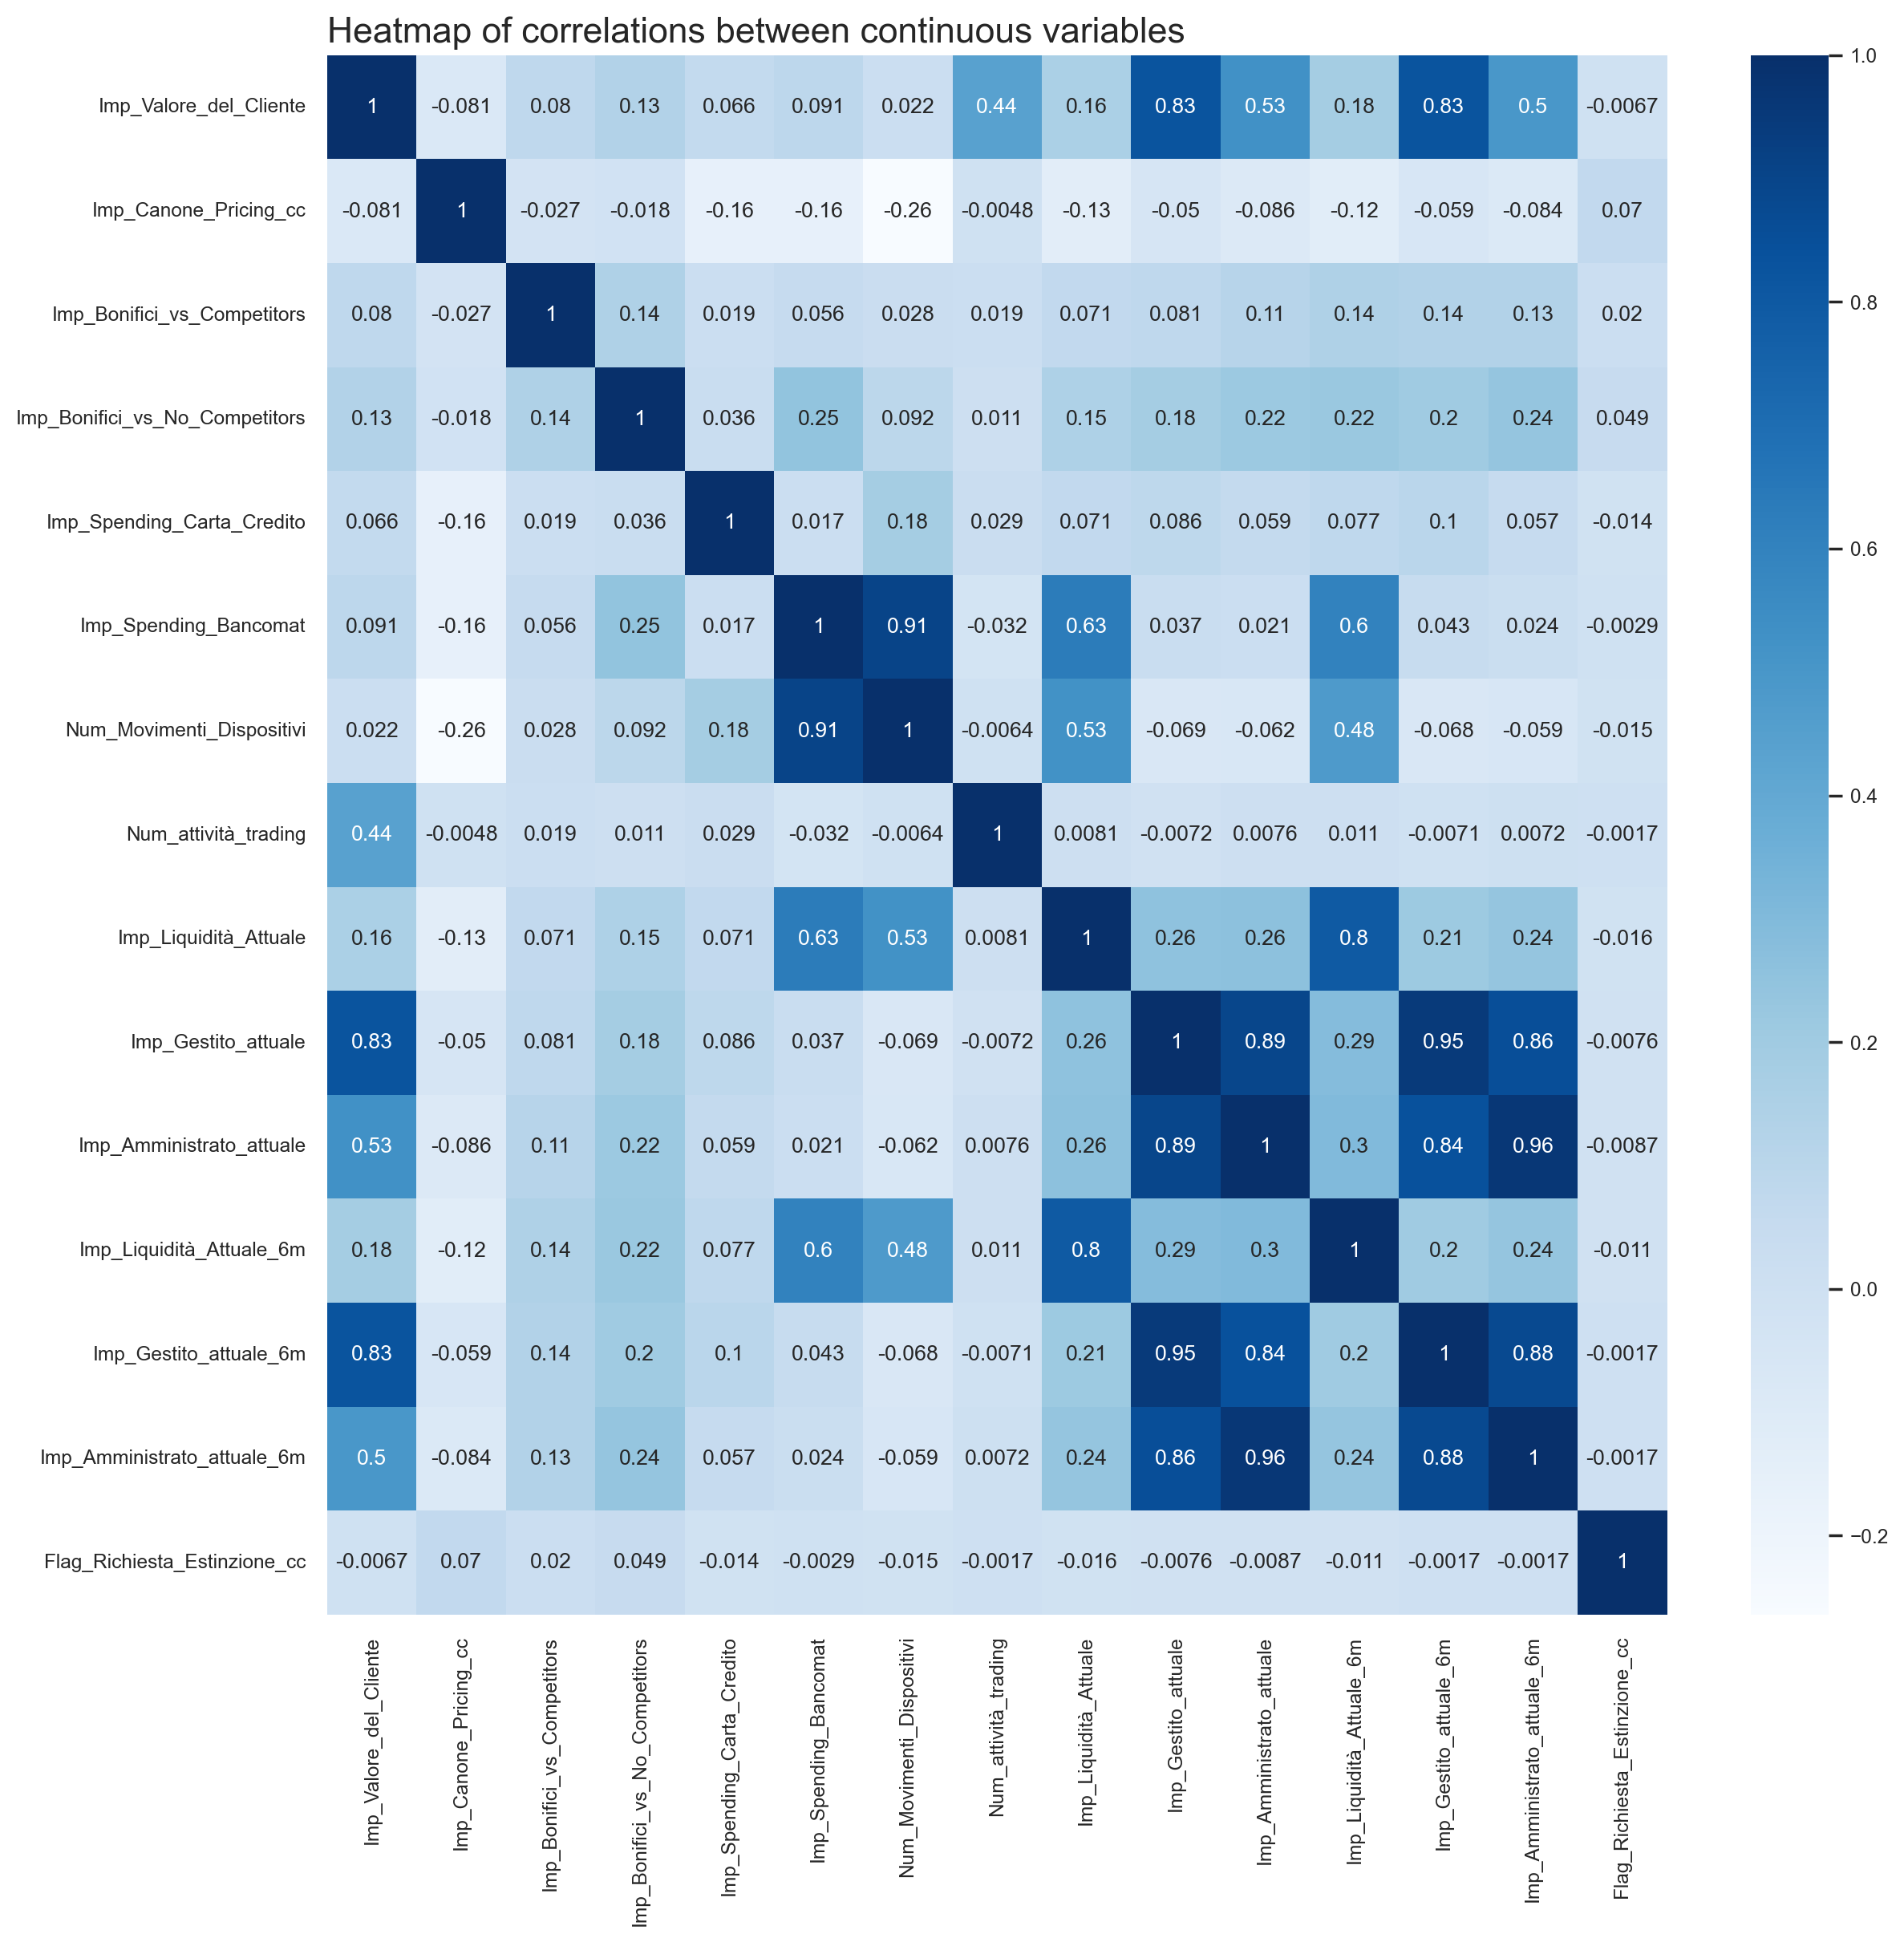

In [34]:
# create heatmap to explore correlations between continuous variables and target
plt.figure(figsize=(12, 12))
plt.title('Heatmap of correlations between continuous variables', loc='left', fontsize = 16)
sns.heatmap(df[continuous_vars+target].corr(), cmap='Blues', annot=True)
plt.show()

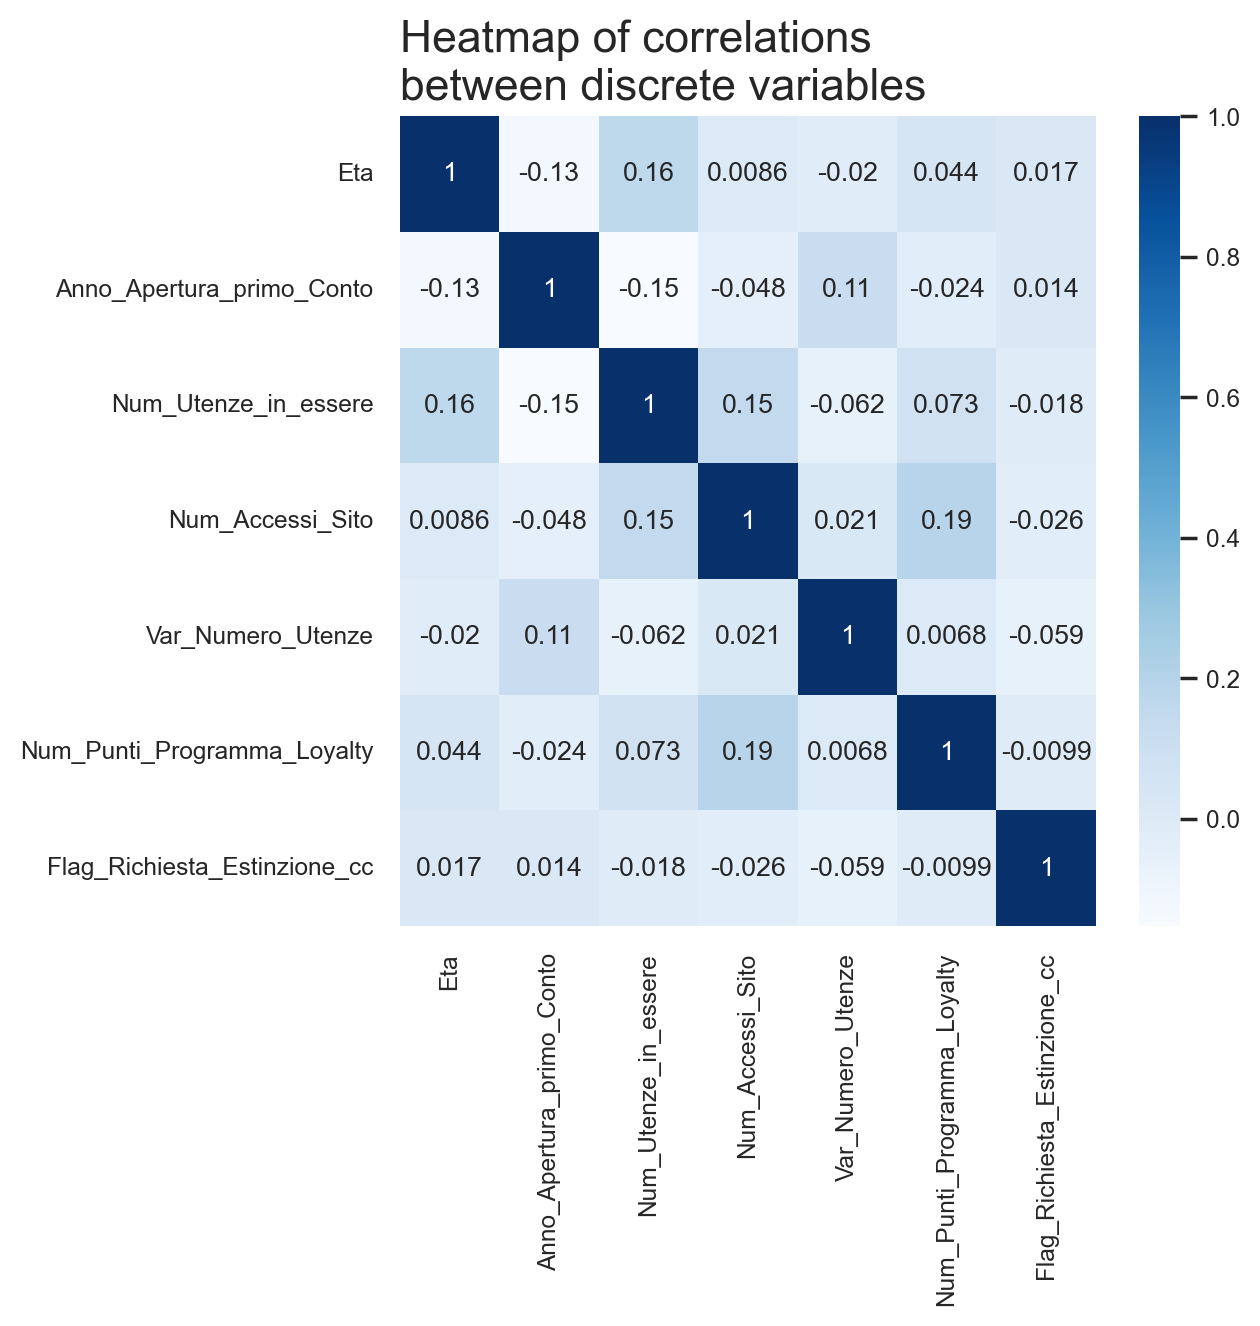

In [35]:
# create heatmap to explore correlations between discrete variables and target
plt.figure(figsize=(5, 5))
plt.title('Heatmap of correlations \nbetween discrete variables', loc='left', fontsize = 16)
sns.heatmap(df[discrete_vars+target].corr(), cmap='Blues', annot=True)
plt.show()

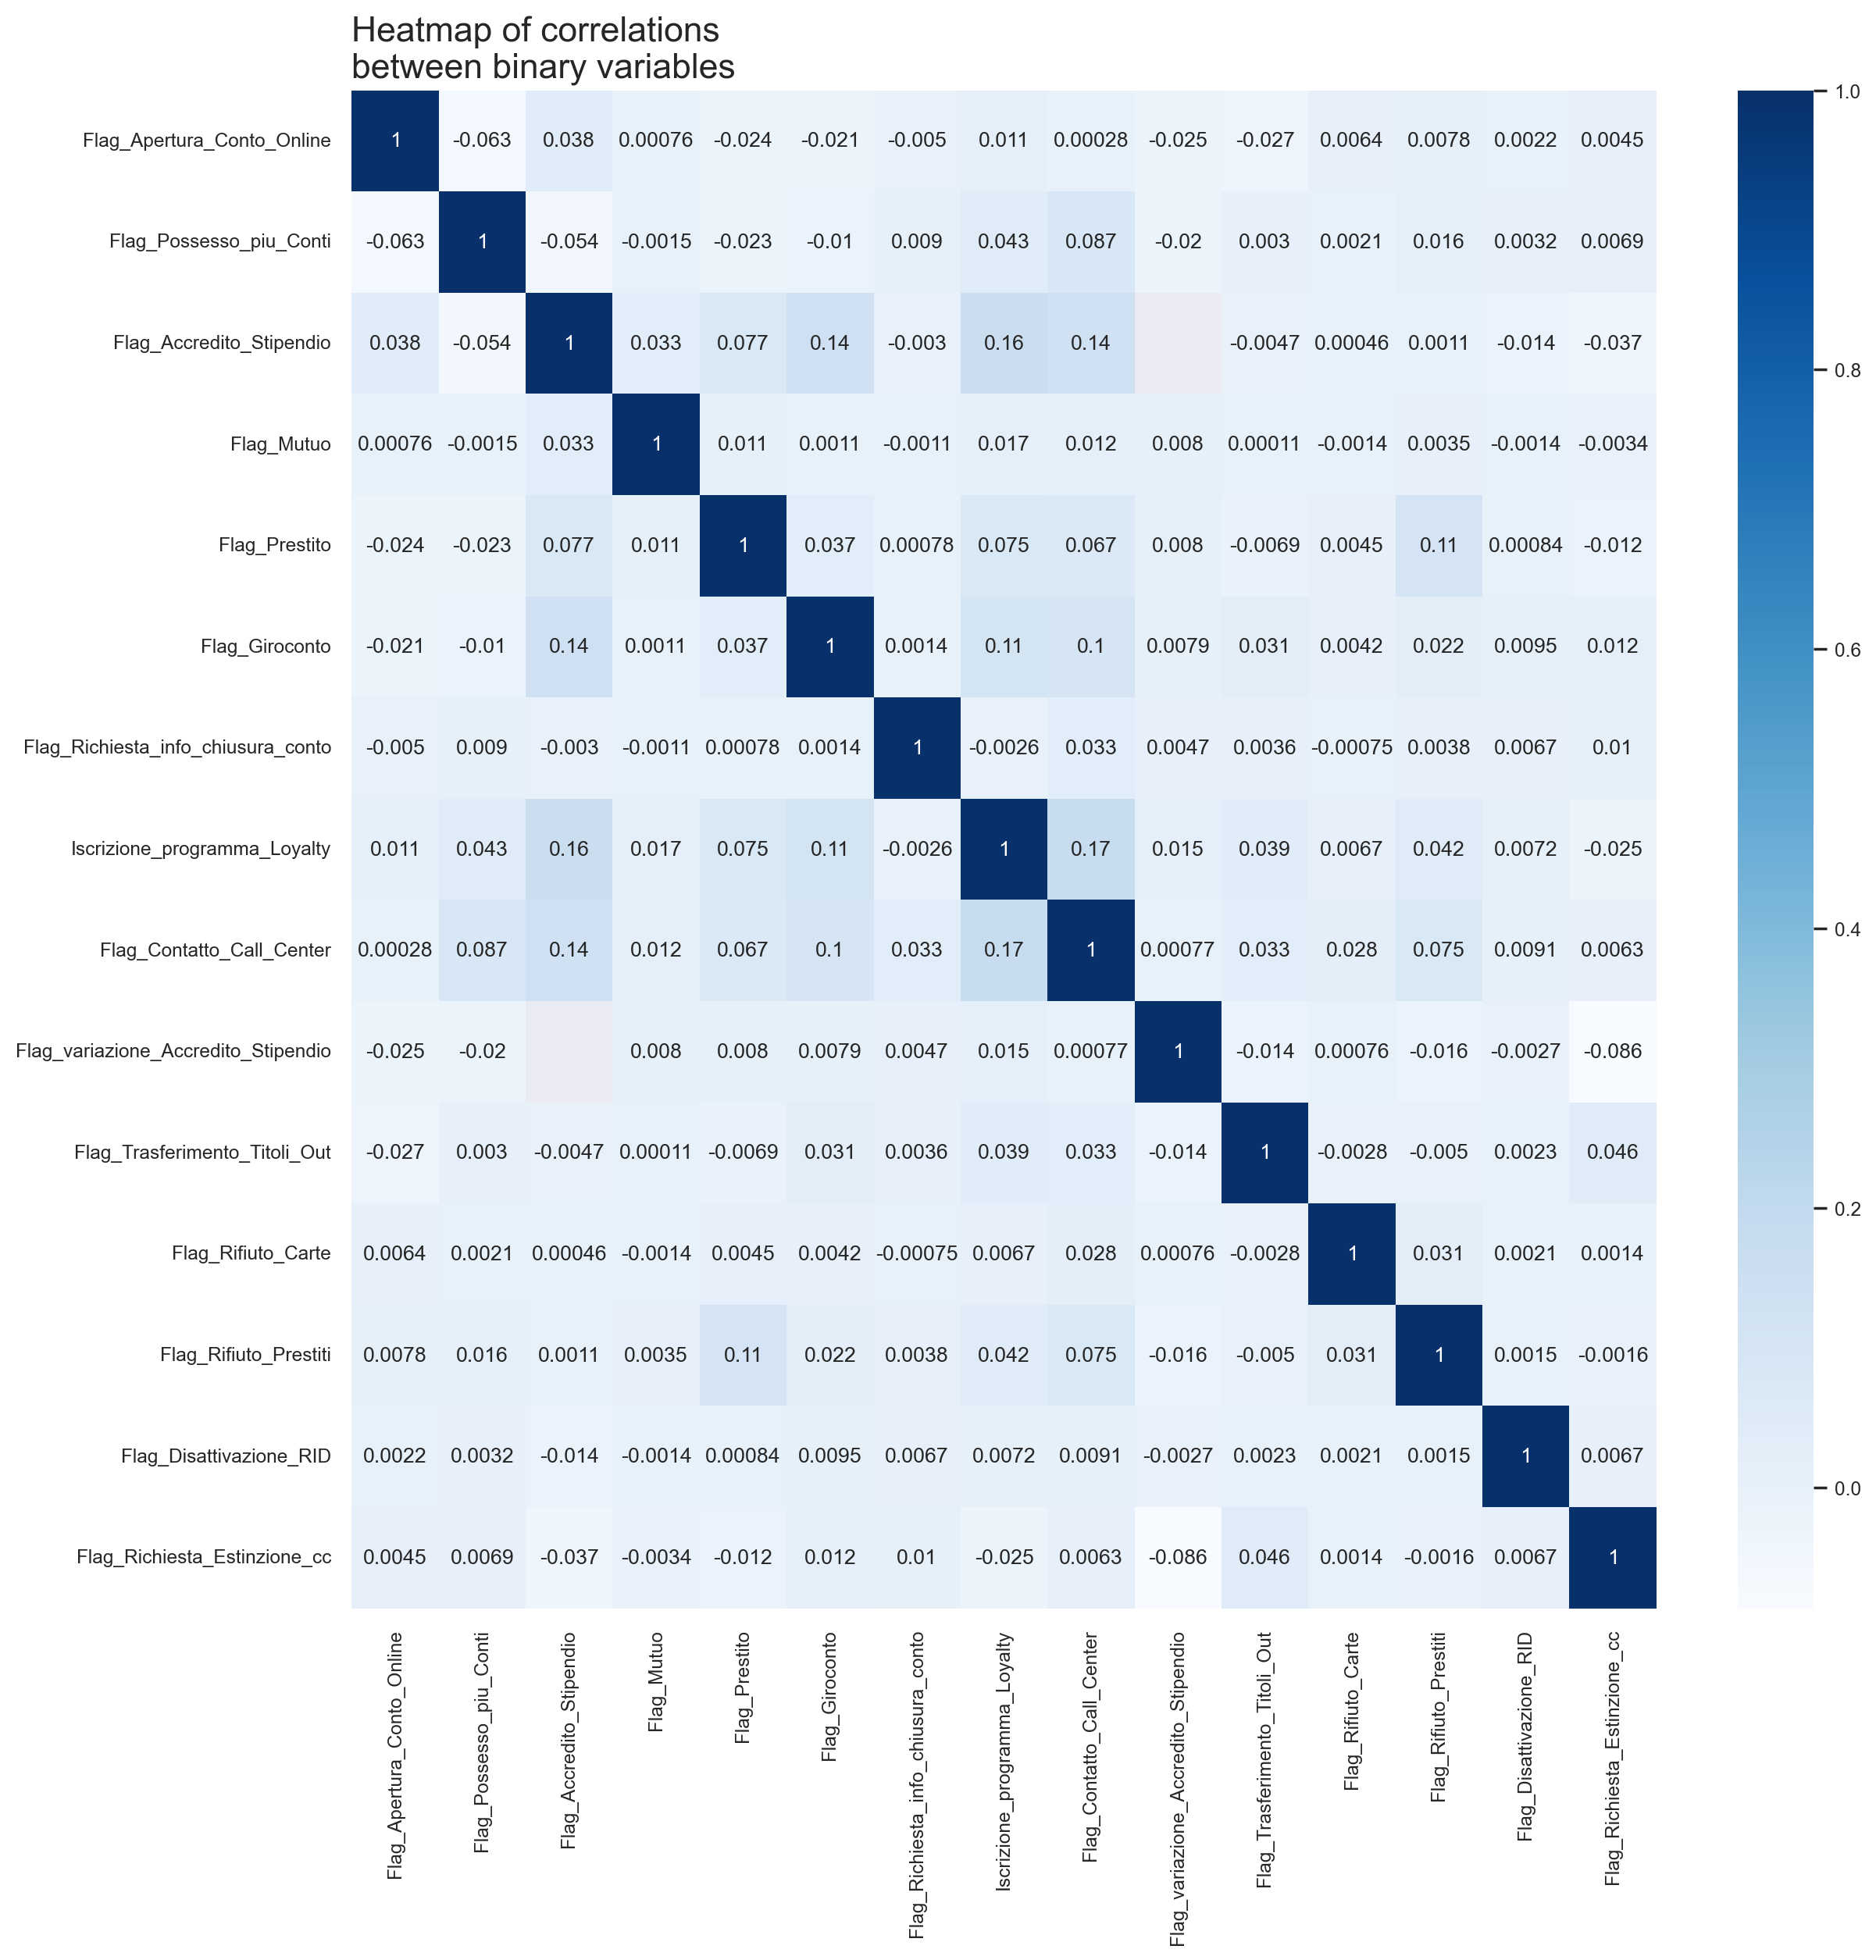

In [36]:
# create heatmap to explore correlations between binary variables and target
plt.figure(figsize=(12, 12))
plt.title('Heatmap of correlations \nbetween binary variables', loc='left', fontsize = 16)
sns.heatmap(df[binary_vars+target].corr(), cmap='Blues', annot=True)
plt.show()

## Exporting the database tables

The 11 tables will be exported as **CSV** files, which will be used to create a semantic model in **Power BI** and related dashboards in the next step.  
  
  <br/><br/>